Nama: Rifdah Hansya Rofifah

Email: rifdahiparifdah@gmail.com

ID Dicoding: rifdahhr

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow

Import library yang dibutuhkan

In [3]:
import pandas as pd
import re
import string
import tensorflow as tf_lib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support


# Data Understanding

Pada tahap ini, terdapat tiga file CSV yang akan digunakan, yaitu kdrama, reviews, dan actors.

In [4]:
kdrama = pd.read_csv('/content/drive/MyDrive/Dataset ML/k-drama-rec/korean_drama.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Dataset ML/k-drama-rec/reviews.csv')
actors = pd.read_csv('/content/drive/MyDrive/Dataset ML/k-drama-rec/wiki_actors.csv')

## K-Drama Variable

Variabel k-drama berisi mengenai informasi mengenai drama korea, seperti nama drama, tahun, sinopsis, dll.

Untuk mengetahui informasi secara umum, kita dapat memanggil fungsi info

In [5]:
kdrama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kdrama_id     1752 non-null   object 
 1   drama_name    1752 non-null   object 
 2   year          1752 non-null   int64  
 3   director      1036 non-null   object 
 4   screenwriter  959 non-null    object 
 5   country       1752 non-null   object 
 6   type          1752 non-null   object 
 7   tot_eps       1752 non-null   int64  
 8   duration      1728 non-null   float64
 9   start_dt      1752 non-null   object 
 10  end_dt        1752 non-null   object 
 11  aired_on      1520 non-null   object 
 12  org_net       1344 non-null   object 
 13  content_rt    1752 non-null   object 
 14  synopsis      1584 non-null   object 
 15  rank          1752 non-null   int64  
 16  pop           1752 non-null   int64  
dtypes: float64(1), int64(4), object(12)
memory usage: 232.8+ KB


Ada missing value untuk dataframe kdrama yang nanti kita akan tangani di proses data preparation

Untuk mengetahui informasi secara umum, kita dapat memanggil fungsi info

In [6]:
kdrama.head()

,kdrama_id,drama_name,year,director,screenwriter,country,type,tot_eps,duration,start_dt,end_dt,aired_on,org_net,content_rt,synopsis,rank,pop
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023","Aug 2, 2023",Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,['Kim Bo Tong'],South Korea,Drama,6,3000.0,"Jul 28, 2023","Jul 28, 2023",Friday,Netflix,15+ - Teens 15 or older,This unfolding story ensues when military dese...,164,1084
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,2023,['Han Dong Hwa'],"['Song Jung Woo', 'Hwang Seol Hun']",South Korea,Drama,8,3300.0,2023-07-05,2023-07-26,Wednesday,Disney+ Hulu,15+ - Teens 15 or older,Unfolds the ultimate counterattack of veteran ...,2443,6915
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,2023,NaN,NaN,South Korea,Drama,3,600.0,2023-06-30,2023-07-14,Friday,NaN,Not Yet Rated,Don't you have those days where the whole univ...,49895,99999
4,04c1fe41948e464fb440001831d74d41,Celebrity,2023,['Kim Chul Gyu'],['Kim Yi Young'],South Korea,Drama,12,2700.0,"Jun 30, 2023","Jun 30, 2023",Friday,Netflix,18+ Restricted (violence & profanity),Fame. Money. Power. One young woman fights to ...,826,547


lihat isi yang ada pada kolom type

In [7]:
print('Banyak Type: ', len(kdrama.type.unique()))
print('Type: ', kdrama.type.unique())

Banyak Type:  1
Type:  ['Drama']


kolom type hanya berisi 1 isi unik yaitu Drama

Lihat isi yang ada pada kolom country

In [8]:
print('Banyak country: ', len(kdrama.country.unique()))
print('country: ', kdrama.country.unique())

Banyak country:  1
country:  ['South Korea']


Ternyata kolom country hanya berisi 1 isi unik yaitu South Korea

Karena nilai dari `type` dan `country` hanya memiliki 1 nilai yang sama untuk semua data, maka kita bisa drop kolom ini nanti.

## Reviews Variabel

Pada variabel reviews berisi mengenai ulasan dan rating drama korea dari users.

Untuk mengetahui informasi secara umum, kita dapat memanggil fungsi info


In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10625 entries, 0 to 10624
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              10625 non-null  object 
 1   title                10625 non-null  object 
 2   story_score          10625 non-null  float64
 3   acting_cast_score    10625 non-null  float64
 4   music_score          10625 non-null  float64
 5   rewatch_value_score  10625 non-null  float64
 6   overall_score        10625 non-null  float64
 7   review_text          10619 non-null  object 
 8   ep_watched           10625 non-null  object 
 9   n_helpful            10625 non-null  int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 830.2+ KB


Bisa kita lihat bahwa di kolom reviews ada beberapa missing value di beberapa kolom, akan tetapi kita hanya mengambil kolom yang diperlukan.

In [10]:
reviews.head()

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121
3,c8ffdab3f2a338eeb54b265598dbbb55,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79
4,c8ffdab3f2a338eeb54b265598dbbb55,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66


## Actors Variable

Variabel actors berisi mengenai informasi actor korea dan drama yang diperani oleh actor tersebut.

Untuk mengetahui informasi secara umum, kita dapat memanggil fungsi info


In [11]:
actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8659 entries, 0 to 8658
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   actor_id        8659 non-null   object
 1   actor_name      8659 non-null   object
 2   drama_name      8659 non-null   object
 3   character_name  8659 non-null   object
 4   role            8659 non-null   object
dtypes: object(5)
memory usage: 338.4+ KB


tidak terdapat missing value pada variabel actor

In [12]:
actors.head()

,actor_id,actor_name,drama_name,character_name,role
0,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Sing My Crush,Han Ba Ram,Main Role
1,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Finland Papa,Toto / Seung Yoon,Support Role
2,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,My Sweet Dear,Ye Jun,Support Role
3,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Lemon Car Video,Jang Do Yoon (Ep. 1),Main Role
4,b5f2eca0-6e6b-474d-88ad-46f4feaa0a8e,Son Hyun Woo,Sing My Crush,Im Han Tae,Main Role


## EDA

<ipython-input-13-06c8b1187c57>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='drama_count', y='actor_name', data=top_actors, palette='viridis')


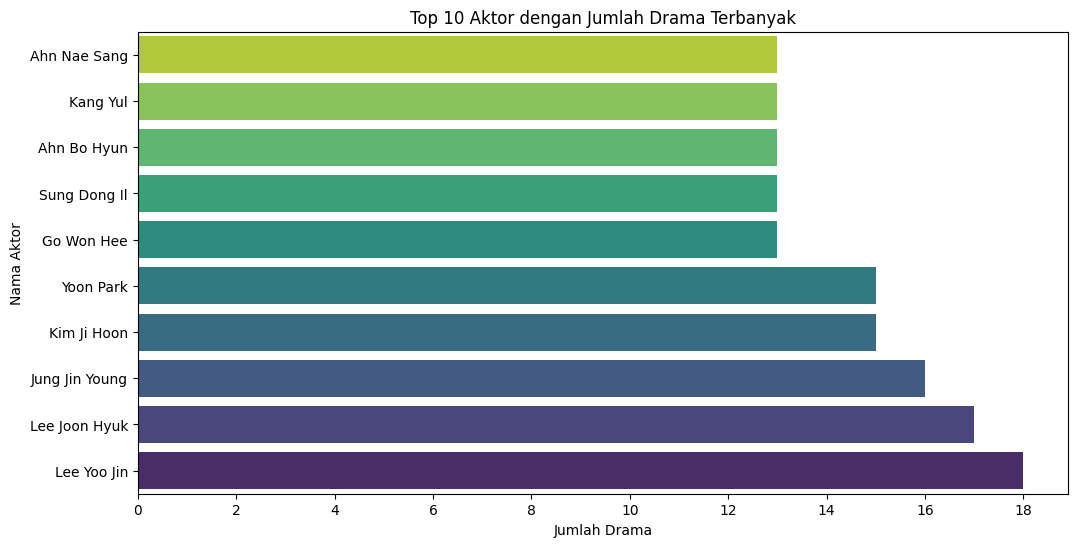

In [13]:
# Visualisasi top 10 aktor dengan drama terbanyak
# Merge kdrama and actors data based on drama title
drama_actor_merge = pd.merge(kdrama, actors, on='drama_name', how='left')

# Group by actor name and count the number of dramas they appeared in
actor_drama_counts = drama_actor_merge.groupby('actor_name')['drama_name'].count().reset_index()
actor_drama_counts = actor_drama_counts.rename(columns={'drama_name': 'drama_count'})
actor_drama_counts = actor_drama_counts.sort_values('drama_count', ascending=False)

# Ambil 10 aktor dengan jumlah drama terbanyak
top_n = 10
top_actors = actor_drama_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x='drama_count', y='actor_name', data=top_actors, palette='viridis')
plt.xlabel('Jumlah Drama')
plt.ylabel('Nama Aktor')
plt.title(f'Top {top_n} Aktor dengan Jumlah Drama Terbanyak')
plt.xticks(np.arange(0, top_actors['drama_count'].max() + 1, 2))
plt.gca().invert_yaxis()
plt.show()


Berdasarkan hasil visualiasi tersebut, aktor Lee Yoo Jin merupakan aktor paling banyak memerankan drama, yaitu sebanyak 18 drama.

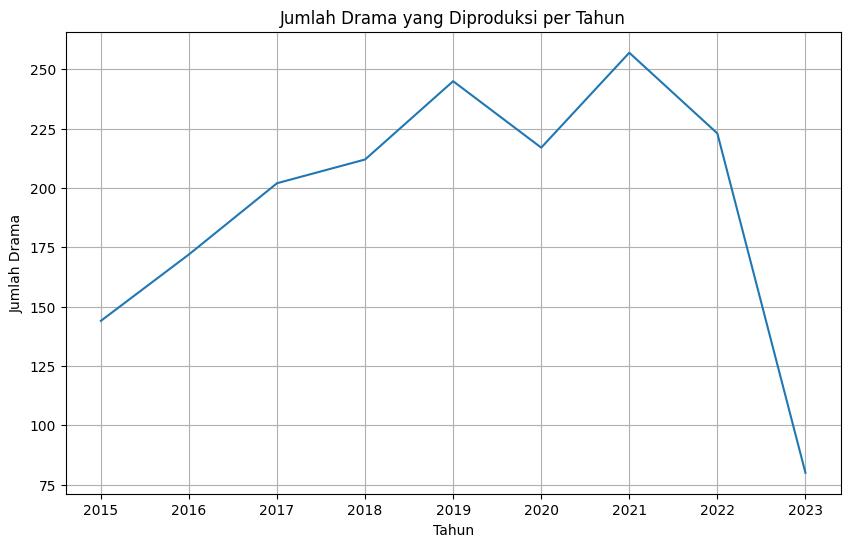

In [14]:
# buat visualisasi jumlah drama yang diproduksi pertahun
drama_per_tahun = kdrama.groupby('year')['drama_name'].count()

# Membuat visualisasi
plt.figure(figsize=(10, 6))
plt.plot(drama_per_tahun.index, drama_per_tahun.values)
plt.xlabel('Tahun')
plt.ylabel('Jumlah Drama')
plt.title('Jumlah Drama yang Diproduksi per Tahun')
plt.grid(True)
plt.show()


Tahun 2021 adalah tahun terbanyak memproduksi drama

# Data Preparation

## Data Preparation untuk Content-based Filtering

### Siapkan dataframe yang dibutuhkan

Variable yang dibutuhkan untum CBF adalah `kdrama` dan `actors`

lakukan merge variabel kdrama dan actors

In [15]:
# merge kdrama dan actors
kdrama_info_df = pd.merge(kdrama, actors, on='drama_name', how='left')
kdrama_info_df.head()

,kdrama_id,drama_name,year,director,screenwriter,country,type,tot_eps,duration,start_dt,...,aired_on,org_net,content_rt,synopsis,rank,pop,actor_id,actor_name,character_name,role
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023",...,Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Han Ba Ram,Main Role
1,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023",...,Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238,b5f2eca0-6e6b-474d-88ad-46f4feaa0a8e,Son Hyun Woo,Im Han Tae,Main Role
2,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023",...,Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238,16dd9bf1-d058-43ed-ba75-330958c9a661,Bang Yoo In,Young Mi,Support Role
3,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023",...,Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238,9ac910e0-0e31-4c09-b5a7-c841dcadffa4,Koo Ja Keon,Jeong Pal,Support Role
4,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,['Kim Bo Tong'],South Korea,Drama,6,3000.0,"Jul 28, 2023",...,Friday,Netflix,15+ - Teens 15 or older,This unfolding story ensues when military dese...,164,1084,bff24fc4-19b0-4418-9b58-9986c0ee602f,Jung Hae In,Ahn Joon Ho,Main Role


drop kolom yang tidak diperlukan

In [16]:
# drop kolom yang tidak diperlukan
columns_to_drop = ['role', 'character_name', 'pop', 'content_rt', 'screenwriter', 'country', 'type', 'start_dt', 'end_dt', 'aired_on', 'org_net', 'rank']
kdrama_info_df = kdrama_info_df.drop(columns=columns_to_drop, errors='ignore')
kdrama_info_df.head(10)

,kdrama_id,drama_name,year,director,tot_eps,duration,synopsis,actor_id,actor_name
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],8,1500.0,Follow the story of acquaintances Ba Ram and H...,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon
1,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],8,1500.0,Follow the story of acquaintances Ba Ram and H...,b5f2eca0-6e6b-474d-88ad-46f4feaa0a8e,Son Hyun Woo
2,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],8,1500.0,Follow the story of acquaintances Ba Ram and H...,16dd9bf1-d058-43ed-ba75-330958c9a661,Bang Yoo In
3,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],8,1500.0,Follow the story of acquaintances Ba Ram and H...,9ac910e0-0e31-4c09-b5a7-c841dcadffa4,Koo Ja Keon
4,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,6,3000.0,This unfolding story ensues when military dese...,bff24fc4-19b0-4418-9b58-9986c0ee602f,Jung Hae In
5,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,6,3000.0,This unfolding story ensues when military dese...,8ec8cb67-6de5-40a0-872e-a8e5c5bd49e7,Koo Kyo Hwan
6,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,6,3000.0,This unfolding story ensues when military dese...,9af0aaf1-102b-4b4c-babd-cdbb91fd61f7,Kim Sung Kyun
7,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,6,3000.0,This unfolding story ensues when military dese...,ae6f79e3-a94e-492d-8d75-6eb797accd72,Son Suk Ku
8,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,6,3000.0,This unfolding story ensues when military dese...,b9c2fd2a-86a8-40c6-86c5-0d0b12397dd1,Kim Ji Hyun
9,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,6,3000.0,This unfolding story ensues when military dese...,2cc4c1b9-5bb7-45f2-8ee2-390add913688,Ji Jin Hee


lakukan grouping pada actor_name menjadi list supaya 1 drama bisa terdapat beberapa aktor dan tidak ada ada duplikasi data, masukkan ke dataframe baru `kdrama_grouped`

In [17]:
#  Lakukan grouping pada actors menjadi sebuah list
kdrama_grouped = kdrama_info_df.groupby('drama_name').agg({
    'kdrama_id': 'first',
    'actor_name': list,
    'year': 'first',
    'director': 'first',
    'tot_eps': 'first',
    'duration': 'first',
    'synopsis': 'first'
}).reset_index()

kdrama_grouped.head()


,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[Jo Sung Ha, Doh Kyung Soo, Kim Jae Young, Nam...",2018,"['Lee Jong Jae', 'Nam Sung Woo']",16,4500.0,"Lee Yul, Crown Prince of Joseon, is a perfecti..."
1,100% Era,4043734ca3a344ceaa5138361f7aafa9,"[Lee Soo Min, Lee Seung Yeon, Yoo Jung Woo, Ye...",2021,None,8,900.0,100% Era imagines the post-corona future. How ...
2,10000 Ways to Become a Couple,fa4d42d8b25a42e0b962fe4e258544b5,[nan],2017,None,5,600.0,‘Are we doing alright?’ From the first fight t...
3,109 Strange Things,fae1a9e517af4a499dd4e5ce17caacef,"[Jung Chae Yeon, Cho Yi Hyun, Choi Tae Joon, ...",2017,None,6,780.0,"When a robot comes from the future, will a phi..."
4,18 Again,d16ff503ce6a4623a631eaeb99e49e15,"[Lee Do Hyun, Ryeoun, Wi Ha Joon, Roh Jeong Eu...",2020,['Ha Byung Hoon'],16,4200.0,"After nearly twenty years of marriage, Jung Da..."


cek informasi df baru `dataframe_grouped`

In [18]:
kdrama_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   drama_name  1752 non-null   object 
 1   kdrama_id   1752 non-null   object 
 2   actor_name  1752 non-null   object 
 3   year        1752 non-null   int64  
 4   director    1036 non-null   object 
 5   tot_eps     1752 non-null   int64  
 6   duration    1728 non-null   float64
 7   synopsis    1584 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 109.6+ KB


cek missing value pada dataframe baru tersebut

In [19]:
# cek missing value
kdrama_grouped.isnull().sum()

,0
drama_name,0
kdrama_id,0
actor_name,0
year,0
director,716
tot_eps,0
duration,24
synopsis,168


Berdasarkan pengecekan tersebut, didapat kolom yang terdapat missing value yaitu kolom `director`, `duration`, dan `synopsis`.

Untuk kolom `director` lakukan pengisian dengan **string kosong**

untuk kolom `duration` diisi denan **mean**

untuk kolom `synopsis` diisi dengan **string kosong**

In [20]:
# Mengatasi Missing value
kdrama_grouped['director'].fillna('', inplace=True)

mean_duration = kdrama_grouped['duration'].mean()
kdrama_grouped['duration'].fillna(mean_duration, inplace=True)

kdrama_grouped['synopsis'].fillna('', inplace=True)


<ipython-input-20-52e7fbcec048>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  kdrama_grouped['director'].fillna('', inplace=True)
<ipython-input-20-52e7fbcec048>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [21]:
# cek kembali missing value setelah dilakukan penanganan
kdrama_grouped.isnull().sum()

,0
drama_name,0
kdrama_id,0
actor_name,0
year,0
director,0
tot_eps,0
duration,0
synopsis,0


Sudah tidak ada missing value setelah dilakukan penanganan

In [22]:
# lihat statistik deskriptif pada kdrama_grouped
kdrama_grouped.describe()

,year,tot_eps,duration
count,1752.000000,1752.000000,1752.000000
mean,2019.006849,18.996005,2149.791667
std,2.317455,25.618394,1521.597331
min,2015.000000,1.000000,60.000000
25%,2017.000000,8.000000,720.000000
50%,2019.000000,12.000000,1920.000000
75%,2021.000000,16.000000,3600.000000
max,2023.000000,150.000000,9180.000000


Tidak ada keanehan pada dataframe tersebut, tahun dimulai dari 2015 hingga 2023

In [23]:
kdrama_grouped.head(10)

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[Jo Sung Ha, Doh Kyung Soo, Kim Jae Young, Nam...",2018,"['Lee Jong Jae', 'Nam Sung Woo']",16,4500.0,"Lee Yul, Crown Prince of Joseon, is a perfecti..."
1,100% Era,4043734ca3a344ceaa5138361f7aafa9,"[Lee Soo Min, Lee Seung Yeon, Yoo Jung Woo, Ye...",2021,,8,900.0,100% Era imagines the post-corona future. How ...
2,10000 Ways to Become a Couple,fa4d42d8b25a42e0b962fe4e258544b5,[nan],2017,,5,600.0,‘Are we doing alright?’ From the first fight t...
3,109 Strange Things,fae1a9e517af4a499dd4e5ce17caacef,"[Jung Chae Yeon, Cho Yi Hyun, Choi Tae Joon, ...",2017,,6,780.0,"When a robot comes from the future, will a phi..."
4,18 Again,d16ff503ce6a4623a631eaeb99e49e15,"[Lee Do Hyun, Ryeoun, Wi Ha Joon, Roh Jeong Eu...",2020,['Ha Byung Hoon'],16,4200.0,"After nearly twenty years of marriage, Jung Da..."
5,187 cm Male Friend vs 155 cm Female Friend,6d273cc558264686b285d56a027670f5,[nan],2020,,3,420.0,"A short, cute drama about friends-to-lovers co..."
6,20+1,d52760463b89456b82774ce735b6aac7,[nan],2019,,6,420.0,
7,2021 Summer Drama Collage: Monster Mansion,2bc3dc40af72441abde7e41d4164e260,"[Park So Jin, Kim Bo Ra, Sung Joon, Kim Hong P...",2021,['Jo Ba Reun'],8,1500.0,An anthology work that captures the strange an...
8,20th Century Boy and Girl,3d0a5b22838c46f0b64f05bfa22e7baa,"[Ahn Se Ha, Ryu Hyun Kyung, Lee Sang Woo, Kim ...",2017,['Lee Dong Yoon'],32,2100.0,A top actress/singer who has an innocent soul ...
9,22 Flower Road,22c5b3ec081d49b48d8c8d0e5e0e2754,"[Jeong Soo Hyun, Hong Bi Ra, Kang Yul, Kim Ye ...",2019,,12,1200.0,"""22 Flower Road"" is a webdrama about young peo..."


Dapat dilihat pada dataframe di atas ternyata masih ada nilai `nan` pada kolom actor_name, maka kita akan mengganti nilai tersebut dengan string kosong

In [24]:
# Ganti nilai NaN pada actor_name menggunakan string kosong
kdrama_grouped['actor_name'] = kdrama_grouped['actor_name'].fillna('')
kdrama_grouped.head()

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[Jo Sung Ha, Doh Kyung Soo, Kim Jae Young, Nam...",2018,"['Lee Jong Jae', 'Nam Sung Woo']",16,4500.0,"Lee Yul, Crown Prince of Joseon, is a perfecti..."
1,100% Era,4043734ca3a344ceaa5138361f7aafa9,"[Lee Soo Min, Lee Seung Yeon, Yoo Jung Woo, Ye...",2021,,8,900.0,100% Era imagines the post-corona future. How ...
2,10000 Ways to Become a Couple,fa4d42d8b25a42e0b962fe4e258544b5,[nan],2017,,5,600.0,‘Are we doing alright?’ From the first fight t...
3,109 Strange Things,fae1a9e517af4a499dd4e5ce17caacef,"[Jung Chae Yeon, Cho Yi Hyun, Choi Tae Joon, ...",2017,,6,780.0,"When a robot comes from the future, will a phi..."
4,18 Again,d16ff503ce6a4623a631eaeb99e49e15,"[Lee Do Hyun, Ryeoun, Wi Ha Joon, Roh Jeong Eu...",2020,['Ha Byung Hoon'],16,4200.0,"After nearly twenty years of marriage, Jung Da..."


Pada nilai director ada tanda ' dan kita akan hapus tanda kutip tersebut

In [25]:
# hapus tanda ' yang ada di kolom director
kdrama_grouped['director'] = kdrama_grouped['director'].str.replace("'", "")
kdrama_grouped.head()

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[Jo Sung Ha, Doh Kyung Soo, Kim Jae Young, Nam...",2018,"[Lee Jong Jae, Nam Sung Woo]",16,4500.0,"Lee Yul, Crown Prince of Joseon, is a perfecti..."
1,100% Era,4043734ca3a344ceaa5138361f7aafa9,"[Lee Soo Min, Lee Seung Yeon, Yoo Jung Woo, Ye...",2021,,8,900.0,100% Era imagines the post-corona future. How ...
2,10000 Ways to Become a Couple,fa4d42d8b25a42e0b962fe4e258544b5,[nan],2017,,5,600.0,‘Are we doing alright?’ From the first fight t...
3,109 Strange Things,fae1a9e517af4a499dd4e5ce17caacef,"[Jung Chae Yeon, Cho Yi Hyun, Choi Tae Joon, ...",2017,,6,780.0,"When a robot comes from the future, will a phi..."
4,18 Again,d16ff503ce6a4623a631eaeb99e49e15,"[Lee Do Hyun, Ryeoun, Wi Ha Joon, Roh Jeong Eu...",2020,[Ha Byung Hoon],16,4200.0,"After nearly twenty years of marriage, Jung Da..."


split isi dari kolom `synopsis` menjadi dipisah per kata

In [26]:
# split synopsis
kdrama_grouped['synopsis'] = kdrama_grouped['synopsis'].apply(lambda x:x.split())
kdrama_grouped.head(1)

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[Jo Sung Ha, Doh Kyung Soo, Kim Jae Young, Nam...",2018,"[Lee Jong Jae, Nam Sung Woo]",16,4500.0,"[Lee, Yul,, Crown, Prince, of, Joseon,, is, a,..."


In [27]:
kdrama_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   drama_name  1752 non-null   object 
 1   kdrama_id   1752 non-null   object 
 2   actor_name  1752 non-null   object 
 3   year        1752 non-null   int64  
 4   director    1752 non-null   object 
 5   tot_eps     1752 non-null   int64  
 6   duration    1752 non-null   float64
 7   synopsis    1752 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 109.6+ KB


kolom `director` belum berupa list, maka kita harus ubah

In [28]:
# Ubah kolom 'director' menjadi list
kdrama_grouped['director'] = kdrama_grouped['director'].apply(lambda x: [x] if isinstance(x, str) else [])
kdrama_grouped.head()

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[Jo Sung Ha, Doh Kyung Soo, Kim Jae Young, Nam...",2018,"[[Lee Jong Jae, Nam Sung Woo]]",16,4500.0,"[Lee, Yul,, Crown, Prince, of, Joseon,, is, a,..."
1,100% Era,4043734ca3a344ceaa5138361f7aafa9,"[Lee Soo Min, Lee Seung Yeon, Yoo Jung Woo, Ye...",2021,[],8,900.0,"[100%, Era, imagines, the, post-corona, future..."
2,10000 Ways to Become a Couple,fa4d42d8b25a42e0b962fe4e258544b5,[nan],2017,[],5,600.0,"[‘Are, we, doing, alright?’, From, the, first,..."
3,109 Strange Things,fae1a9e517af4a499dd4e5ce17caacef,"[Jung Chae Yeon, Cho Yi Hyun, Choi Tae Joon, ...",2017,[],6,780.0,"[When, a, robot, comes, from, the, future,, wi..."
4,18 Again,d16ff503ce6a4623a631eaeb99e49e15,"[Lee Do Hyun, Ryeoun, Wi Ha Joon, Roh Jeong Eu...",2020,[[Ha Byung Hoon]],16,4200.0,"[After, nearly, twenty, years, of, marriage,, ..."


Hapus spasi yang ada pada kolom `actor_name`, `director`, dan `synopsis`

In [29]:
# hapus spasi
kdrama_grouped['actor_name'] = kdrama_grouped['actor_name'].apply(lambda x: [str(i).replace(" ", "") for i in x])
kdrama_grouped['director'] = kdrama_grouped['director'].apply(lambda x: [str(i).replace(" ", "") for i in x])
kdrama_grouped['synopsis'] = kdrama_grouped['synopsis'].apply(lambda x: [str(i).replace(" ", "") for i in x])

kdrama_grouped.head()

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[JoSungHa, DohKyungSoo, KimJaeYoung, NamJiHyun...",2018,"[[LeeJongJae,NamSungWoo]]",16,4500.0,"[Lee, Yul,, Crown, Prince, of, Joseon,, is, a,..."
1,100% Era,4043734ca3a344ceaa5138361f7aafa9,"[LeeSooMin, LeeSeungYeon, YooJungWoo, YeoJiMin...",2021,[],8,900.0,"[100%, Era, imagines, the, post-corona, future..."
2,10000 Ways to Become a Couple,fa4d42d8b25a42e0b962fe4e258544b5,[nan],2017,[],5,600.0,"[‘Are, we, doing, alright?’, From, the, first,..."
3,109 Strange Things,fae1a9e517af4a499dd4e5ce17caacef,"[JungChaeYeon, ChoYiHyun, ChoiTaeJoon, KimYong...",2017,[],6,780.0,"[When, a, robot, comes, from, the, future,, wi..."
4,18 Again,d16ff503ce6a4623a631eaeb99e49e15,"[LeeDoHyun, Ryeoun, WiHaJoon, RohJeongEui, Kim...",2020,[[HaByungHoon]],16,4200.0,"[After, nearly, twenty, years, of, marriage,, ..."


buat kolom baru bernama `tags` yang menyatukan 3 kolom (synopsis, actor_name, dan director)

In [30]:
# kelompokkan kolom synopsis, actor_name, dan director ke dalam kolom tags
kdrama_grouped['tags'] = kdrama_grouped['synopsis'] + kdrama_grouped['actor_name'] + kdrama_grouped['director']
kdrama_grouped.head(1)

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis,tags
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[JoSungHa, DohKyungSoo, KimJaeYoung, NamJiHyun...",2018,"[[LeeJongJae,NamSungWoo]]",16,4500.0,"[Lee, Yul,, Crown, Prince, of, Joseon,, is, a,...","[Lee, Yul,, Crown, Prince, of, Joseon,, is, a,..."


lihat tags pada indeks ke 0

In [31]:
kdrama_grouped['tags'][0]

['Lee',
 'Yul,',
 'Crown',
 'Prince',
 'of',
 'Joseon,',
 'is',
 'a',
 'perfectionist',
 'who',
 'disregards',
 'most',
 'royal',
 'palace',
 'nobles.',
 'His',
 'cold',
 'and',
 'demanding',
 'demeanor',
 'masks',
 'deeply-rooted',
 'loneliness.',
 'He',
 'comes',
 'to',
 'pass',
 'a',
 'law',
 'stating',
 'that',
 'Korean',
 'citizens',
 'of',
 'marriageable',
 'age',
 'must',
 'wed',
 'before',
 'the',
 'age',
 'of',
 '28.Hong',
 'Shim',
 'is',
 'a',
 'strong,',
 'intelligent',
 'woman',
 'who',
 'supports',
 'herself',
 'and',
 'her',
 'father.',
 'After',
 'an',
 'attempt',
 'on',
 'his',
 'life,',
 'Crown',
 'Prince',
 'Lee',
 'Yul',
 'is',
 'severely',
 'injured',
 'and',
 'finds',
 'himself',
 'under',
 'the',
 'care',
 'of',
 'the',
 'Hong',
 'household.',
 'He’s',
 'experiencing',
 'temporary',
 'amnesia,',
 'and',
 'now',
 'unaware',
 'of',
 'his',
 'identity,',
 'he',
 'is',
 'free',
 'to',
 'wander',
 'at',
 'will',
 'as',
 'a',
 'commoner.Due',
 'to',
 'the',
 'law,',
 'h

gabungkan semua elemen dari tags ke dalam satu string dengan spasi sebagai pemisah


In [32]:
kdrama_grouped['tags'] = kdrama_grouped['tags'].apply(lambda x: " ".join(x))
kdrama_grouped.head(1)

,drama_name,kdrama_id,actor_name,year,director,tot_eps,duration,synopsis,tags
0,100 Days My Prince,53c858d11a284859a1f50699b5aa6f51,"[JoSungHa, DohKyungSoo, KimJaeYoung, NamJiHyun...",2018,"[[LeeJongJae,NamSungWoo]]",16,4500.0,"[Lee, Yul,, Crown, Prince, of, Joseon,, is, a,...","Lee Yul, Crown Prince of Joseon, is a perfecti..."


bisa dilihat pada kolom tags tersebut sudah menjadi sebuah kesatuan


In [33]:
kdrama_grouped['tags'][0]

'Lee Yul, Crown Prince of Joseon, is a perfectionist who disregards most royal palace nobles. His cold and demanding demeanor masks deeply-rooted loneliness. He comes to pass a law stating that Korean citizens of marriageable age must wed before the age of 28.Hong Shim is a strong, intelligent woman who supports herself and her father. After an attempt on his life, Crown Prince Lee Yul is severely injured and finds himself under the care of the Hong household. He’s experiencing temporary amnesia, and now unaware of his identity, he is free to wander at will as a commoner.Due to the law, he himself passed, Hong Shim, now the oldest unmarried woman in her village, must marry or face punishment from officials. Lee Yul proposes to Hong Shim that they ought to marry. Can their budding romance withstand Lee Yul’s eventual recovery, with his memory fully intact?(Source: AJ and Lee C at MyDramaList) JoSungHa DohKyungSoo KimJaeYoung NamJiHyun HanSoHee KimSeonHo [LeeJongJae,NamSungWoo]'

jika kita perhatikan kolom tags pada indeks ke 0 tersebut masih ada beberapa hal yang perlu kita bersihkan, seperti masih adanya uppercase, ada kata-kata yang tidak diperlukan, dan masih ada tanda baca.

In [34]:
kdrama_grouped['tags'] = kdrama_grouped['tags'].apply(lambda x:x.lower()) # ubah menjadi lowercase
kdrama_grouped['tags'] = kdrama_grouped['tags'].apply(lambda x: re.sub(r"\(source:.*?\)", "", x)) # hapus source
kdrama_grouped['tags'] = kdrama_grouped['tags'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))  # Hapus tanda baca
kdrama_grouped['tags'][0]

'lee yul crown prince of joseon is a perfectionist who disregards most royal palace nobles his cold and demanding demeanor masks deeplyrooted loneliness he comes to pass a law stating that korean citizens of marriageable age must wed before the age of 28hong shim is a strong intelligent woman who supports herself and her father after an attempt on his life crown prince lee yul is severely injured and finds himself under the care of the hong household he’s experiencing temporary amnesia and now unaware of his identity he is free to wander at will as a commonerdue to the law he himself passed hong shim now the oldest unmarried woman in her village must marry or face punishment from officials lee yul proposes to hong shim that they ought to marry can their budding romance withstand lee yul’s eventual recovery with his memory fully intact josungha dohkyungsoo kimjaeyoung namjihyun hansohee kimseonho leejongjaenamsungwoo'

Setelah cleaning selesai, buat dataframe baru

In [35]:
# buat dataframe kdrama_df
kdrama_df = kdrama_grouped[["kdrama_id", "drama_name", "tags"]]
kdrama_df.head()

,kdrama_id,drama_name,tags
0,53c858d11a284859a1f50699b5aa6f51,100 Days My Prince,lee yul crown prince of joseon is a perfection...
1,4043734ca3a344ceaa5138361f7aafa9,100% Era,100 era imagines the postcorona future how the...
2,fa4d42d8b25a42e0b962fe4e258544b5,10000 Ways to Become a Couple,‘are we doing alright’ from the first fight to...
3,fae1a9e517af4a499dd4e5ce17caacef,109 Strange Things,when a robot comes from the future will a phil...
4,d16ff503ce6a4623a631eaeb99e49e15,18 Again,after nearly twenty years of marriage jung da ...


### TF-IDF Vectorizer

Pada tahap ini, kita akan melakukan perhitungan tf-idf pada kolom tags

In [36]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(kdrama_df['tags'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['01', '02', '10', ..., '홍종현', '홍천기', '흠념뇸'], dtype=object)

ubah teks dalam kolom "tags" pada dataset kdrama_df menjadi representasi vektor menggunakan TF-IDF dan tampilkan ukuran matriks hasil transformasi.

In [37]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(kdrama_df['tags'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(1752, 15592)

In [38]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

tampilkan sampel kecil dari matriks TF-IDF untuk mempermudah visualisasi

In [39]:
# Membuat dataframe untuk melihat tf-idf matrix
num_cols = tfidf_matrix.shape[1]
num_rows = tfidf_matrix.shape[0]

num_cols_to_sample = min(22, num_cols)
num_rows_to_sample = min(10, num_rows)

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=kdrama_df.drama_name
).sample(num_cols_to_sample, axis=1).sample(num_rows_to_sample, axis=0)

,flaming,600,perform,affairs,endocrinologist,fbi,worst,songjiwoo,differentiate,unimaginable,...,precarious,leehwiseo,fightdetermined,ulterior,kimkyutae,pinnacle,each,institution,engagement,affluent
drama_name,,,,,,,,,,,,,,,,,,,,,
Let Me Be Your Knight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
The Man of My Life,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
"Cheat On Me, if You Can",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
The Sound of Magic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.047461,0.0,0.0,0.0
Oh My Geum Bi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
LOVE up-date,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Prince's Prince,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Jeju Sea Water,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Hit the Spot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Data Preparation untuk Collaborative Filtering

### Siapkan dataframe dengan kolom yang dibutuhkan

Pada Collaborative Filtering, hanya akan menggunakan varible reviews dan kdrama (hanya mengambil kolom kdrama_id)

In [40]:
reviews.head()

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121
3,c8ffdab3f2a338eeb54b265598dbbb55,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79
4,c8ffdab3f2a338eeb54b265598dbbb55,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66


gabungkan dataframe reviews dengan kdrama (hanya mengambil kolom kdrama_id nya saja pada df kdrama)

In [41]:
# merge reviews dengan kdrama (mengambil kdrama_id)
reviews_grouped = pd.merge(reviews, kdrama[['kdrama_id', 'drama_name']], left_on='title', right_on='drama_name', how='left')
reviews_grouped.head()

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful,kdrama_id,drama_name
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31,95b9396130b1478398d12faf08797097,Happy Merry Ending
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2
3,c8ffdab3f2a338eeb54b265598dbbb55,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim
4,c8ffdab3f2a338eeb54b265598dbbb55,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner


konversi user_id lalu buat mapping nya supaya dapat dilakukan perhitungan

In [42]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = reviews_grouped['user_id'].unique().tolist()
print('list user_id: ', user_ids)

# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke user_id: ', user_encoded_to_user)

list user_id:  ['c8ffdab3f2a338eeb54b265598dbbb55', '01b015525e8f34ba9e776af1dadc7610', '02daa3d8e7eb36b3b3a2dec5fc4eb9cd', '1c8bbd8058fd3e719def4cc3746ffd59', 'b1c75f6a89893578b904b21d3612a036', '5a66c5f1a2b23c9e905e91c2d328015a', 'cb8ef7667add3299bade908f708b36a2', '99c183eb5b9435119b7a5ff2f5164941', '2dd2ff45ac40396fa3a82f935fb72593', '4957f97b45bd3329a2e8428a3a2d31e7', 'ef2ab82895583156914ff3980525a01c', '1f5a2b2c5896306aa6375257b0d0d887', '5b94afef16f53ae1a277a35f148727f7', 'a738d2c7283a38309b4cf97629990296', '7a38b70ac6ce3530843cf86fa1520b21', '201994e537753654818be8c25cee5ad4', 'b2c381f809ee37a4a59888832213bd65', '19e190dc616d3696bf19019955a2f272', '602578cd61653deba845b40799ea7df9', '1933258ee8783e02aa231a423d884268', '4297266302c53cb1813b38211e6490c4', '8c3d2946f44e34eeba4c135731045839', 'ff53c06a28ea37cc8e36d8a29af65af9', '5b2c202af84130d0aac1a0b525d4c35f', 'ae0450a485073607855652ba7215911d', 'f04b2b96640e3374b738db6d15880e30', '5114de62a4aa3e3fbd3df4368841a30e', '832b9d0965e

In [43]:
# Mapping userID ke dataframe user
reviews_grouped['user_encode'] = reviews_grouped['user_id'].map(user_to_user_encoded)
reviews_grouped.head()

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful,kdrama_id,drama_name,user_encode
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,0
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31,95b9396130b1478398d12faf08797097,Happy Merry Ending,0
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,0
3,c8ffdab3f2a338eeb54b265598dbbb55,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,0
4,c8ffdab3f2a338eeb54b265598dbbb55,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,0


Dapat dilihat terdapat kolom duplikat yang menampung judul drama korea, yaitu pada kolom title dan drama_name, sehingga kita harus drop salah satu kolom tersebut

In [44]:
# drop kolom title karena duplikat dati drama_name
reviews_grouped = reviews_grouped.drop('title', axis=1)
reviews_grouped.head()

,user_id,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful,kdrama_id,drama_name,user_encode
0,c8ffdab3f2a338eeb54b265598dbbb55,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,0
1,c8ffdab3f2a338eeb54b265598dbbb55,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31,95b9396130b1478398d12faf08797097,Happy Merry Ending,0
2,c8ffdab3f2a338eeb54b265598dbbb55,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,0
3,c8ffdab3f2a338eeb54b265598dbbb55,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,0
4,c8ffdab3f2a338eeb54b265598dbbb55,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,0


Konversi nilai drama dan lakukan mapping supaya bisa dilakukan perhitungan

In [45]:
# Mengubah drama menjadi list tanpa nilai yang sama
dramas = reviews_grouped['kdrama_id'].unique().tolist()
print('list dramas: ', dramas)

# Melakukan encoding drama
drama_to_drama_encoded = {x: i for i, x in enumerate(dramas)}
print('encoded drama : ', drama_to_drama_encoded)

# Melakukan proses encoding angka ke ke drama
drama_encoded_to_drama = {i: x for i, x in enumerate(dramas)}
print('encoded angka ke drama: ', drama_encoded_to_drama)


list dramas:  ['661d4193916c4e71a2c70473ab11e9e8', '95b9396130b1478398d12faf08797097', '6b7782a36bfd47a4a787018ab0b3c5fb', 'f9860c4b65b746d7af2b545cd152a4b6', 'd6f2eb3a6fb7426587a69d9ea607ec68', '9f18660af3e84496b65832d2e8b36c5b', '1c135017a2ca403fb696b333753a71e1', '38bed0dcd0644ee897ef84d587aabd78', '49846934ef8d4b719668046fe9b1b2a9', '7edb2a10033f41a89fc05a1dc564698a', 'd2e509b0293549bab62b76a9f8630956', 'ec80f88a2e594a909facc164a0d73363', '4ca05130abbe465e9977b7f163968e0f', 'fa66edaa18174140a493953f362adb82', 'bff00514de05407aadfe5e46df7e6ee5', '52225793342e440d90354d4a0f305586', '8057ee35785644d5b7b09042e559776e', '62cf5f2690c54981a959fdfa618605ab', 'ddc829b4c170484d94efedfb4cb29f3d', 'b27d22a8e87b4749a532a276d1b3d196', '3207a7aab81a42d49d024ef616f4d254', '49f2d0c965754bddb0da5f1b26a2ceb0', 'c8e2ead5aba445e7a4c501c77dc4272c', '78ff11b4301b4694a73b510e34a5d03d', '47b65449450d478c96e0612571583cdf', '84f5fe50666c49a7b6f06f000cf9d25f', '13e0534998514029bd39c66254b65035', '345d9671f999

In [46]:
# Mapping drama ke dataframe reviews_grouped
reviews_grouped['kdrama_encode'] = reviews_grouped['kdrama_id'].map(drama_to_drama_encoded)
reviews_grouped.head()

,user_id,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful,kdrama_id,drama_name,user_encode,kdrama_encode
0,c8ffdab3f2a338eeb54b265598dbbb55,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,0,0
1,c8ffdab3f2a338eeb54b265598dbbb55,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31,95b9396130b1478398d12faf08797097,Happy Merry Ending,0,1
2,c8ffdab3f2a338eeb54b265598dbbb55,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,0,2
3,c8ffdab3f2a338eeb54b265598dbbb55,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,0,3
4,c8ffdab3f2a338eeb54b265598dbbb55,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,0,4


Hitung jumlah user dan cari nilai maksimum dan minimum dari overall_score

In [47]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah drama
num_drama = len(drama_to_drama_encoded)
print(num_drama)

# Nilai minimum overall_score
min_overall_score = min(reviews['overall_score'])

# Nilai maksimal overall_score
max_overall_score = max(reviews['overall_score'])

print('Number of User: {}, Number of drama: {}, Min overall_score: {}, Max overall_score: {}'.format(
    num_users, num_drama, min_overall_score, max_overall_score
))

4562
1279
Number of User: 4562, Number of drama: 1279, Min overall_score: 1.0, Max overall_score: 10.0


Buat dataframe baru dengan kolom yang dibutuhkan

In [48]:
# buat dataframe dengan kolom-kolom yang dibutuhkan
reviews_df = reviews_grouped[['user_id', 'kdrama_id', 'drama_name', 'overall_score', 'user_encode', 'kdrama_encode']]
reviews_df.head()

,user_id,kdrama_id,drama_name,overall_score,user_encode,kdrama_encode
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,9.0,0,0
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,Happy Merry Ending,6.5,0,1
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,4.0,0,2
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,9.0,0,3
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,7.0,0,4


### Split Data

Membagi data untuk training dan validasi

In [49]:
# Membuat variabel x untuk mencocokkan data user dan kdrama menjadi satu value
x = reviews_df[['user_encode', 'kdrama_encode']].values

# Membuat variabel y untuk membuat rating dari hasil
y = reviews_df['overall_score'].apply(lambda x: (x - min_overall_score) / (max_overall_score - min_overall_score)).values

# Membagi menjadi 80% data train, 10% data validasi, dan 10% data test
train_indices = int(0.8 * reviews_df.shape[0])
val_indices = int(0.9 * reviews_df.shape[0])
x_train, x_val, x_test, y_train, y_val, y_test = (
    x[:train_indices],
    x[train_indices:val_indices],
    x[val_indices:],
    y[:train_indices],
    y[train_indices:val_indices],
    y[val_indices:]
)

print(x, y)

[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [4559  448]
 [4560  448]
 [4561  448]] [0.88888889 0.61111111 0.33333333 ... 0.5        0.94444444 0.27777778]


# Modeling

## Content-based Filtering

Setelah menghitung TF-IDF pada tahap data preparation, selanjutnya di modeling CBF ini kita akan hitung terlebih dahulu consine similarity nya

### Cosine Similarity

In [51]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.04439783, 0.04766669, ..., 0.03725751, 0.02214526,
        0.09719092],
       [0.04439783, 1.        , 0.04512411, ..., 0.04925483, 0.06535824,
        0.0963325 ],
       [0.04766669, 0.04512411, 1.        , ..., 0.06769642, 0.04525665,
        0.06123505],
       ...,
       [0.03725751, 0.04925483, 0.06769642, ..., 1.        , 0.05974366,
        0.04914698],
       [0.02214526, 0.06535824, 0.04525665, ..., 0.05974366, 1.        ,
        0.02116232],
       [0.09719092, 0.0963325 , 0.06123505, ..., 0.04914698, 0.02116232,
        1.        ]])

 tampilkan kemiripan antar drama berdasarkan similarity matrix tersebut

In [52]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama drama
cosine_sim_df = pd.DataFrame(cosine_sim, index=kdrama_df['drama_name'], columns=kdrama_df['drama_name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap drama
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1752, 1752)


drama_name,I Have Not Done My Best Yet,Sweet Stranger and Me,Beginning,Night of Love,Strong Woman Do Bong Soon
drama_name,,,,,
Yellow,0.055814,0.070656,0.032028,0.032547,0.052721
Brilliant Heritage,0.092560,0.045366,0.042663,0.056862,0.066231
Love Affairs in the Afternoon,0.019835,0.082682,0.030865,0.039747,0.065651
Oh My Grace,0.026099,0.055574,0.067262,0.026242,0.076123
Phantom School,0.060805,0.044001,0.095992,0.071704,0.127863
Revolutionary Sisters,0.125004,0.133106,0.077211,0.022364,0.130021
"Hello, Stranger",0.000000,0.000000,0.000000,0.000000,0.000000
Between Friendship and Love Season 3,0.046197,0.051390,0.027091,0.047168,0.067789
Secret Royal Inspector,0.092386,0.065088,0.056084,0.038938,0.062395


### Mendapat Rekomendasi CBF

kita akan coba berikan rekomendasi drama berdasarkan kemiripan yang diberikan dan menampilkan k rekomendasi teratas

In [53]:
def drama_recommendations(nama_drama, similarity_data=cosine_sim_df, items=kdrama_df[['drama_name', 'tags']], k=5):
    """
    Rekomendasi drama berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_drama : tipe data string (str)
                Nama Drama (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan drama sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_drama].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_drama agar nama drama yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_drama, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

kita akan menampilkan rekomendasi drama yang mirip dengan kdrama yang berjudul '18 Again'

In [54]:
# drop 18 again agar tidak muncul dalam daftar rekomendasi yg diberikan, mau nyari yg mirip sm 18 Again
kdrama_df[kdrama_df.drama_name.eq('18 Again')]

,kdrama_id,drama_name,tags
4,d16ff503ce6a4623a631eaeb99e49e15,18 Again,after nearly twenty years of marriage jung da ...


In [55]:
# Mendapatkan rekomendasi drama yang mirip dengan 18 Again
drama_recommendations('18 Again')

,drama_name,tags
0,The Great Show,wie dae han is an exlawmaker and is a material...
1,The Killer's Shopping List,despite having an excellent memory ahn dae sun...
2,Happy Ending Romance,cha jung woo might have had a bright future as...
3,Hope or Dope 2,having been used as a drug mule by her parents...
4,A Shoulder to Cry On,at school lee da yeol spends most of his time ...


## Collaborative Filtering

Pada modeling dengan Collaborative filtering kita akan menggunakan pendekatan Neural Collaborative Filtering (NCF). Kita akan menggunakan RecommenderNet untuk mengimplementasikannya

In [57]:
class RecommenderNet(tf_lib.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_drama, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_drama = num_drama
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf_lib.keras.regularizers.l2(1e-6) # change keras to tf_lib.keras
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.drama_embedding = layers.Embedding( # layer embeddings drama
        num_drama,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf_lib.keras.regularizers.l2(1e-6) # change keras to tf_lib.keras
    )
    self.drama_bias = layers.Embedding(num_drama, 1) # layer embedding drama bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    drama_vector = self.drama_embedding(inputs[:, 1]) # memanggil layer embedding 3
    drama_bias = self.drama_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_drama = tf_lib.tensordot(user_vector, drama_vector, 2) # change tf to tf_lib

    x = dot_user_drama + user_bias + drama_bias

    return tf_lib.nn.sigmoid(x) # activation sigmoid # change tf to tf_lib

Inisialisasi model dengan menggunakan Adam optimizer dan RMSE sebagai metrik evaluasi.

In [58]:
model = RecommenderNet(num_users, num_drama, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf_lib.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf_lib.keras.metrics.RootMeanSquaredError()]
)

Lakukan training dengan batch_size bernilai 8 dan 30 epoch

In [59]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 30, # menggunakan 30
    validation_data = (x_val, y_val)
)

Epoch 1/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.6864 - root_mean_squared_error: 0.3212 - val_loss: 0.6819 - val_root_mean_squared_error: 0.3439
Epoch 2/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.5976 - root_mean_squared_error: 0.2496 - val_loss: 0.6766 - val_root_mean_squared_error: 0.3398
Epoch 3/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.5588 - root_mean_squared_error: 0.2154 - val_loss: 0.6747 - val_root_mean_squared_error: 0.3383
Epoch 4/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.5515 - root_mean_squared_error: 0.2029 - val_loss: 0.6715 - val_root_mean_squared_error: 0.3359
Epoch 5/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5415 - root_mean_squared_error: 0.1980 - val_loss: 0.6685 - val_root_mean_squared_error: 0.3337
Epoch 6/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.5363 - root_mean_squared_error: 0.1891 - val_loss: 0.6655 - val_root_mean_squared_error: 0.3314
Epoch 7/30
1063/1063 ━━━━━━━━━━━

# Evaluasi

## Evaluasi CF


Evaluasi Collaborative Filtering (CF) dengan menggunakan Root Mean Squared Error (RMSE)

In [60]:
# Evaluasi pada data validasi
val_loss, val_rmse = model.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Evaluasi pada data uji
test_loss, test_rmse = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6483 - root_mean_squared_error: 0.3188
Validation Loss: 0.6347
Validation RMSE: 0.3096
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6508 - root_mean_squared_error: 0.3233
Test Loss: 0.6609
Test RMSE: 0.3281


### Visualisasi Metrik

Buat visualiasi dari hasil evaluasi supaya lebih mudah dibaca

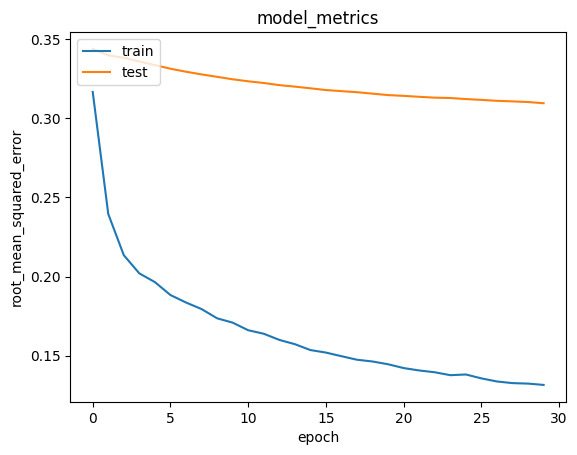

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Mendapatkan rekomendasi drama hasil CF

Siapkan data pengguna dan drama yg belum ditonton untuk mendapat rekomendasi dengan CF

In [62]:
drama_df = kdrama_df

user_id = reviews_df['user_id'].sample(1).iloc[0]
drama_watched_by_user = reviews_df[reviews_df['user_id'] == user_id]

drama_not_watched = drama_df[~drama_df['kdrama_id'].isin(drama_watched_by_user['kdrama_encode'].values)]['kdrama_id']
drama_not_watched = list(
    set(drama_not_watched)
    .intersection(set(drama_to_drama_encoded.keys()))
)

drama_not_watched = [[drama_to_drama_encoded.get(x)] for x in drama_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_drama_array = np.hstack(
    ([[user_encoder]] * len(drama_not_watched), drama_not_watched)
)



Berikan rekomendasi drama berdasarkan ulasan pengguna, dengan menampilkan drama yang telah ditonton dan rekomendasi drama lainnya yang sesuai dengan preferensi pengguna

In [63]:
reviews_model = model.predict(user_drama_array).flatten()

top_reviews_indices = reviews_model.argsort()[-10:][::-1]

recommended_drama_ids = [
    drama_encoded_to_drama.get(drama_not_watched[x][0]) for x in top_reviews_indices
]

top_drama_user = (
    drama_watched_by_user.sort_values(
        by='overall_score',
        ascending=False
    )
    .head(10)['kdrama_encode'].values
)

drama_df_rows = drama_df[drama_df['kdrama_id'].isin(top_drama_user)]

# Displays drama recommendations in DataFrame form
drama_df_rows_data = []
for row in drama_df_rows.itertuples():
    drama_df_rows_data.append([row.drama_name, row.tags])

recommended_drama = drama_df[drama_df['kdrama_id'].isin(recommended_drama_ids)]

recommended_drama_data = []
for row in recommended_drama.itertuples():
    recommended_drama_data.append([row.drama_name, row.tags])

# Create a DataFrame for output
output_columns = ['drama Title', 'drama tags']
df_drama_watched_by_user = pd.DataFrame(drama_df_rows_data, columns=output_columns)
df_recommended_dramas = pd.DataFrame(recommended_drama_data, columns=output_columns)

# Displays recommendation results in DataFrame form
print("Showing recommendation for users: {}".format(user_id))
print("===" * 9)
print("drama with high reviews from user")
print("----" * 8)
print(df_drama_watched_by_user)
print("----" * 8)
print("Top 10 dramas recommendation")
print("----" * 8)
df_recommended_dramas

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Showing recommendation for users: 6420cae938fa346c9be829aef6b5608f
drama with high reviews from user
--------------------------------
Empty DataFrame
Columns: [drama Title, drama tags]
Index: []
--------------------------------
Top 10 dramas recommendation
--------------------------------


,drama Title,drama tags
0,Children of Nobody,cha woo kyung is a child counselor who works a...
1,Crazy Love,no go jin is the most popular mathematics inst...
2,Heard It Through the Grapevine,han jeong ho and choi yeon hee are a wealthy c...
3,Missing: The Other Side Season 2,3 gongdan is a village where missing deceased ...
4,Move to Heaven,han geu roo is an autistic 20yearold he works ...
5,Our Blues,our blues takes on an omnibusstyle drama which...
6,Our Dating Sim,a story about what happens when two men who ha...
7,Take 1,what if you could only leave one stage before ...
8,The Fiery Priest,kim hae il is a catholic priest he makes spite...
9,Youth of May,hee tae becomes the pride of gwangju when he e...


## Evaluasi CBF

Evaluasi CBF menggunakan metriks evaluasi precision, recall, dan F1-score untuk mengukur performa model berdasarkan prediksi yang dihasilkan dari cosine similarity dan ground truth.

Tentukan nilai threshold untuk menghitung matriks ground_truth berdasarkan nilai cosine similarity. Jika ada dua kdrama yang memiliki nilai similarity lebih besar atau sama dengan threshold yang ditentukan, maka keduanya dianggap relevan (diberi label 1 dalam matriks ground_truth).


In [65]:
threshold = 0.6

ground_truth = np.where(cosine_sim >= threshold, 1, 0)

ground_truth_df = pd.DataFrame(ground_truth, index=kdrama_df['drama_name'], columns=kdrama_df['drama_name']).sample(15, axis=1).sample(15, axis=0)

ambil subset dari matriks cosine_sim dan ground_truth sebanyak 10.000 data, meratakannya menjadi array satu dimensi, dan kemudian membandingkannya dengan threshold untuk menghasilkan prediksi biner. Prediksi ini kemudian dievaluasi menggunakan metrik precision, recall, dan F1-score untuk mengukur performa model.

In [66]:
sample_size = 10000
cosine_sim_sample = cosine_sim[:sample_size, :sample_size]
ground_truth_sample = ground_truth[:sample_size, :sample_size]

cosine_sim_flat = cosine_sim_sample.flatten()

ground_truth_flat = ground_truth_sample.flatten()

predictions = (cosine_sim_flat >= threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
     ground_truth_flat, predictions, average='binary', zero_division=1
)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


Berdarkan metriks evaluasi tersebut, model memiliki performa yang sangat baik, dengan precision, recall, dan F1-score semuanya mencapai 1.0, yang menunjukkan bahwa model memberikan rekomendasi dengan sangat baik tanpa kesalahan atau false positive/negative.